In [481]:
import numpy as np
from scipy import io

In [482]:
data1 = io.loadmat('ex5data1.mat')
X = data1['X']
y = data1['y']
Xtest = data1['Xtest']
ytest = data1['ytest']
Xval = data1['Xval']
yval = data1['yval']
print(X.shape, y.shape)

(12, 1) (12, 1)


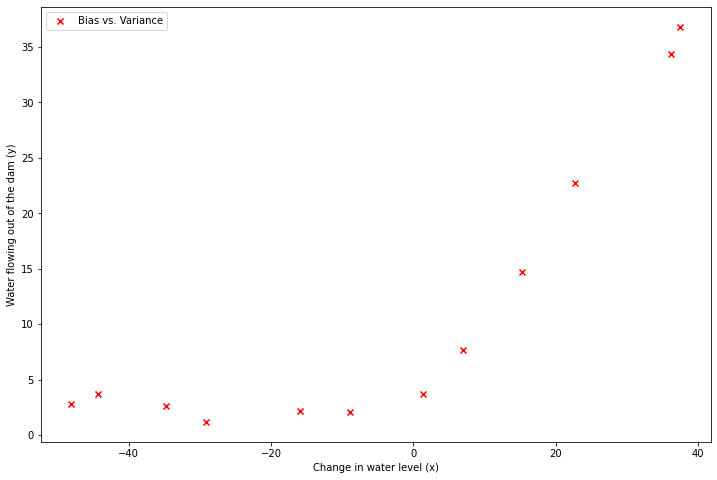

In [483]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(figsize=(12,8))
ax.scatter(X, y, c='r', marker='x', label='Bias vs. Variance')
ax.legend(loc='best')
ax.set_xlabel('Change in water level (x)')
ax.set_ylabel('Water flowing out of the dam (y)')
plt.show()

In [484]:
def linearRegCostFunction(theta, X, y, r=1):
    X_tmp = np.insert(X, 0, 1, axis=1)
    theta = np.matrix(theta)
    term = np.dot(X_tmp, theta.T) - y
    loss = np.sum(np.multiply(term, term))
    penalty = np.sum(np.multiply(theta[:,1:],theta[:,1:])) * r
    ret = (loss + penalty) / (len(X_tmp) * 2)
    return ret

In [485]:
theta = np.ones((1, X.shape[1]+1))
linearRegCostFunction(theta, X, y)

303.9931922202643

In [486]:
def gradient(theta, X, y, r=1):
    X_tmp = np.insert(X, 0, 1, axis=1)
    theta = theta.reshape(1, X_tmp.shape[1])
    error = np.dot(X_tmp, theta.T) - y
    loss = np.dot(error.T, X_tmp)
    tmp_theta = np.zeros_like(theta)
    tmp_theta[:, 1:] = theta[:, 1:]
    penalty = r * tmp_theta
    return np.array((loss + penalty)) / len(y)

In [487]:
gradient(theta, X, y)
gradient(theta, X, y)
gradient(theta, X, y)

array([[-15.30301567, 598.25074417]])

In [488]:
X.shape, y.shape, type(theta), theta.shape, np.matrix(theta).shape

((12, 1), (12, 1), numpy.ndarray, (1, 2), (1, 2))

In [489]:
from scipy import optimize
r = 1
result = optimize.minimize(fun=linearRegCostFunction,x0=theta,args=(X, y, r),method='TNC', jac=gradient, options={'disp': True})

In [490]:
result

     fun: 22.379541822940322
     jac: array([[ 3.27512342e-07, -1.70992000e-08]])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 9
     nit: 4
  status: 1
 success: True
       x: array([13.0877145,  0.367742 ])

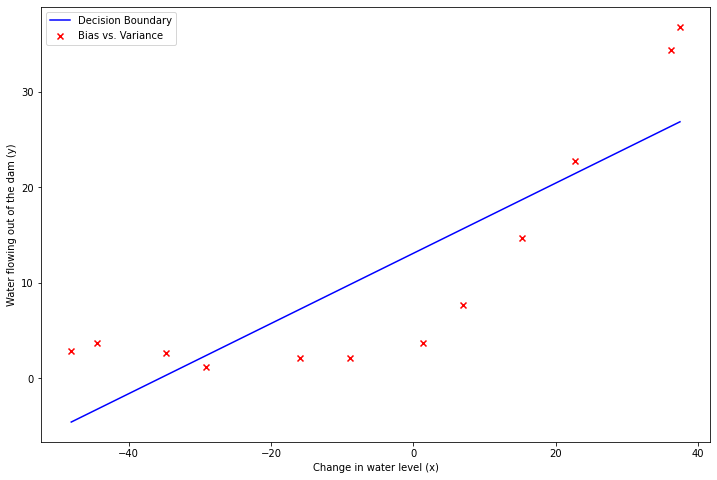

In [491]:
_, ax = plt.subplots(figsize=(12,8))
test_x = np.linspace(X.min(), X.max(), 100)
test_y = result.x[0] + test_x*result.x[1]
ax.plot(test_x, test_y, c='b', label='Decision Boundary')
ax.scatter(X, y, c='r', marker='x', label='Bias vs. Variance')
ax.legend(loc='best')
ax.set_xlabel('Change in water level (x)')
ax.set_ylabel('Water flowing out of the dam (y)')
plt.show()

In [492]:
import ml

In [493]:
class Net(ml.Module):
    def __init__(self, lr=1e-3, r=1):
        super(Net, self).__init__(lr=lr, r=r)
        self.layers = [
            ml.FC('fc', 1, 1)
        ]

In [494]:
net = Net(lr=5e-4)
net.layers[0].weights = np.array([[14.0]])
net.layers[0].bias = 1.0
for epoch in range(10):
    y_pred = net.forward(X)
    loss, loss_diff = ml.MSELoss.update(y, y_pred)
    net.backward(loss_diff)
    print('epoch: {}, loss: {} '.format(epoch, loss))
print(net.layers[0].weights, net.layers[0].bias)
    

epoch: 0, loss: 79812.58631258768 
epoch: 1, loss: 26451.693571053005 
epoch: 2, loss: 8807.638354218678 
epoch: 3, loss: 2973.6127655533205 
epoch: 4, loss: 1044.6149057729085 
epoch: 5, loss: 406.80307553809456 
epoch: 6, loss: 195.90372372193397 
epoch: 7, loss: 126.14869228202896 
epoch: 8, loss: 103.05355647720465 
epoch: 9, loss: 95.38066400509827 
[[0.34994891]] [1.13983334]


In [495]:
def learningCurve(theta, X, y, Xval, yval, r):
    error_train = []
    error_val = []
    theta_result = theta.copy()
    for i in range(len(X)):
        result = optimize.minimize(fun=linearRegCostFunction, x0=theta, method='TNC', jac=gradient, args=(X[:i+1, :], y[:i+1, :], r))
        error_train.append(result.fun)
        error_val.append(linearRegCostFunction(result.x, Xval, yval, r))
        theta_result = result.x
    return error_train, error_val, theta_result

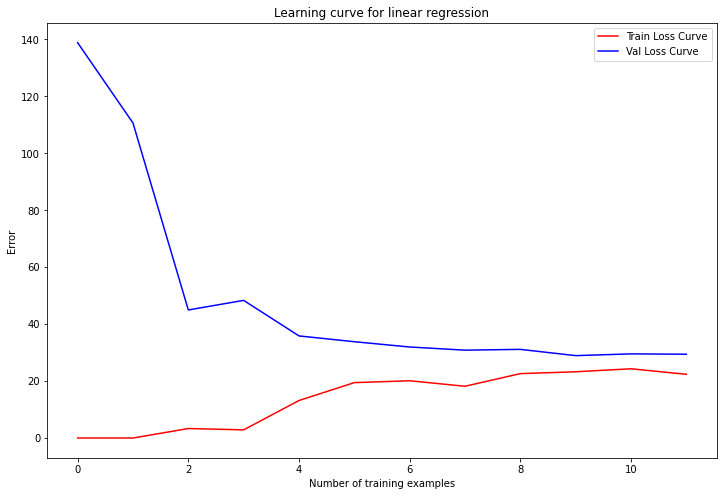

In [496]:
theta0 = np.ones((1, X.shape[1]+1))
error_train, error_val, _ = learningCurve(theta0, X, y, Xval, yval, 1.0)
_, ax = plt.subplots(figsize=(12, 8))
ax.plot(error_train, c='r', label='Train Loss Curve')
ax.plot(error_val, c='b', label='Val Loss Curve')
ax.legend(loc='best')
ax.set_xlabel('Number of training examples')
ax.set_ylabel('Error')
ax.set_title('Learning curve for linear regression')
plt.show()

In [497]:
def polyFeatures(X, n):
    Xtmp = X.copy()
    for i in range(n):
        Xtmp = np.insert(Xtmp, i+1, Xtmp[:,0]**(i+2), axis=-1)
    return Xtmp

In [498]:
def featureNormalize(X):
    Xtmp = X.copy()
    for i in range(X.shape[1]):
        Xtmp[:,i] = (X[:, i] - X[:, i].mean()) / X[:, i].std()
    return Xtmp

In [499]:
polyX = polyFeatures(X, 7)
polyXval = polyFeatures(Xval, 7)
polyX = featureNormalize(polyX)
polyXval = featureNormalize(polyXval)

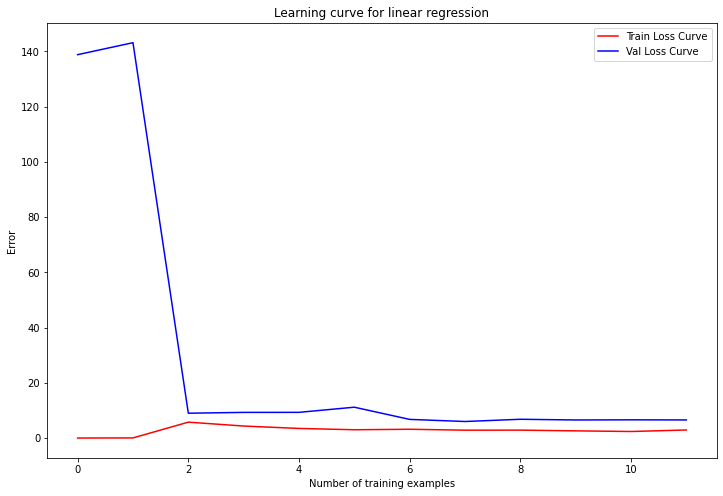

In [500]:
theta0 = np.ones((1, polyX.shape[1]+1))
error_train, error_val, result_theta = learningCurve(theta0, polyX, y, polyXval, yval, 0.3)
_, ax = plt.subplots(figsize=(12, 8))
ax.plot(error_train, c='r', label='Train Loss Curve')
ax.plot(error_val, c='b', label='Val Loss Curve')
ax.legend(loc='best')
ax.set_xlabel('Number of training examples')
ax.set_ylabel('Error')
ax.set_title('Learning curve for linear regression')
plt.show()

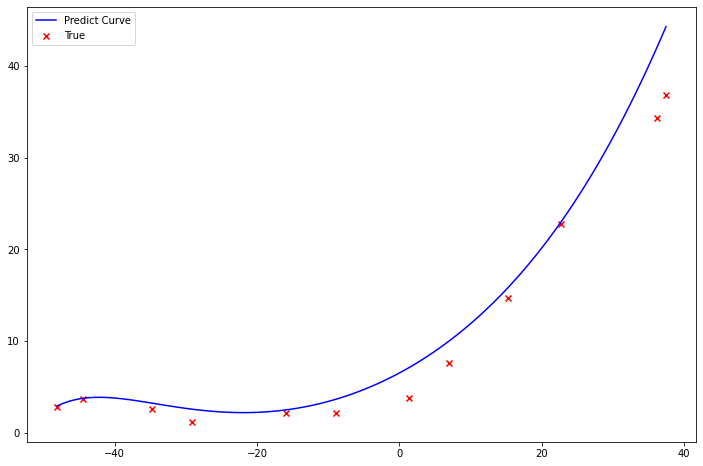

In [501]:
x_predict = np.linspace(X.min(), X.max(),100).reshape(100, 1)
x_predict_poly = polyFeatures(x_predict, 7)
x_predict_poly_norm = np.insert(featureNormalize(x_predict_poly), 0, 1, axis=1)
y_predict = np.dot(x_predict_poly_norm, result_theta.T)
_, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_predict, y_predict, c='b', label='Predict Curve')
ax.scatter(X, y, c='r', marker='x', label='True')
ax.legend(loc='best')
plt.show()